In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


In [ ]:
df = pd.read_csv('completed_temperature_data_autoencoder (1).csv')

In [ ]:
df.head()

,1,2,3,4,5,6,7,8,9,10,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
0,4.785580,4.900576,4.859008,4.885932,4.770386,4.729796,4.774939,4.910201,4.725148,4.803974,...,4.543592,4.495877,4.503518,4.527897,4.596917,4.566005,4.525138,4.431546,4.480712,4.547918
1,5.728863,5.857020,5.798181,5.933707,5.884749,5.719563,5.719676,5.901783,5.753826,5.789667,...,5.246141,5.330088,5.214275,5.286959,5.368566,5.312683,5.306678,5.174341,5.232470,5.297327
2,4.103804,4.158539,4.114476,4.181690,4.197443,4.200930,4.173109,4.100515,4.247186,4.137102,...,4.563403,4.791807,4.532488,4.630761,4.685237,4.753214,4.502262,4.657535,4.660212,4.766862
3,5.328878,5.282985,5.260376,5.176813,5.239027,5.176700,5.212803,5.232375,5.151106,5.197009,...,5.548029,5.469950,5.556752,5.447971,5.508282,5.431012,5.417532,5.420098,5.462794,5.484062
4,5.377637,5.327459,5.305333,5.218909,5.290562,5.226020,5.256990,5.273446,5.200563,5.246951,...,5.610126,5.533165,5.623560,5.514461,5.574389,5.490835,5.472900,5.481764,5.527007,5.546203


In [ ]:
missing_values_count = df.isna().sum().sum()
print(f"Number of missing values: {missing_values_count}")

Number of missing values: 0


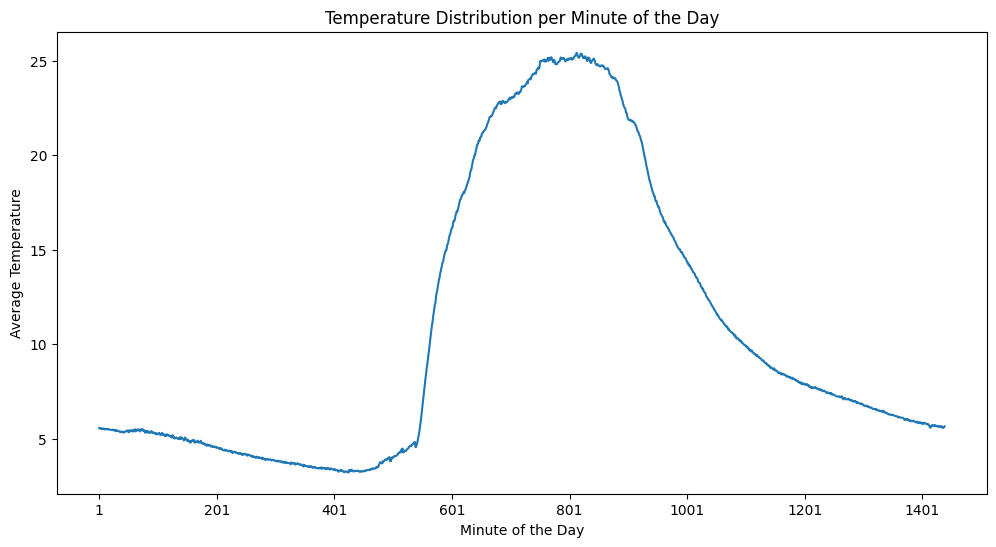

In [ ]:
plt.figure(figsize=(12, 6))
df.mean(axis=0).plot()
plt.title('Temperature Distribution per Minute of the Day')
plt.xlabel('Minute of the Day')
plt.ylabel('Average Temperature')
plt.show()

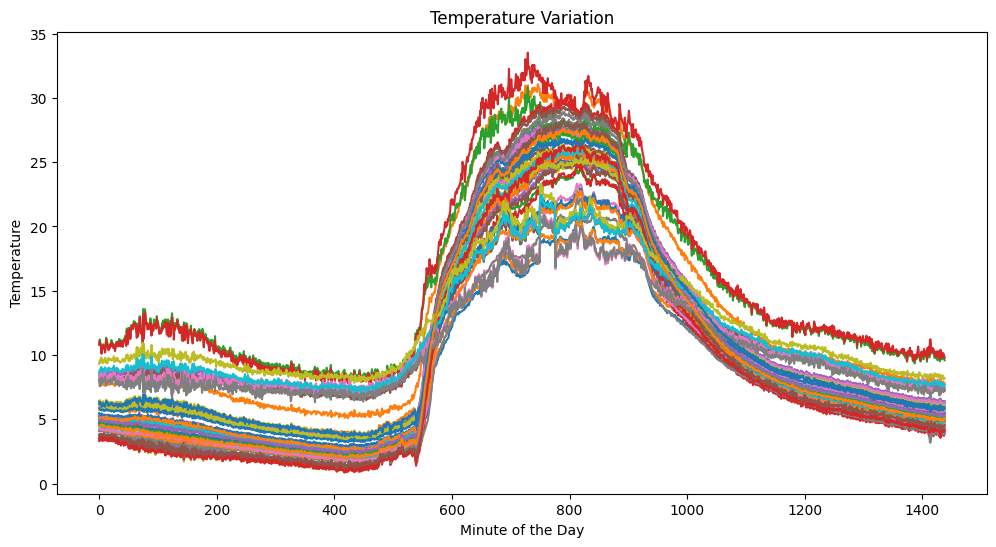

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.values.T)
plt.title('Temperature Variation')
plt.xlabel('Minute of the Day')
plt.ylabel('Temperature')
plt.show()

In [ ]:

train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)


In [ ]:

# Preprocess the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)



In [ ]:

#Autoencoder model
input_dim = train_data_scaled.shape[1]
encoding_dim = 128
autoencoder = Sequential([
    Dense(encoding_dim, activation='relu', input_shape=(input_dim,)),
    Dense(64, activation='sigmoid'),
    Dense(32, activation='sigmoid'),
    Dense(16, activation='sigmoid'),
    Dense(8, activation='sigmoid'),
    Dense(16, activation='sigmoid'),
    Dense(32, activation='sigmoid'),
    Dense(64, activation='sigmoid'),
    Dense(128, activation='sigmoid'),
    Dense(input_dim, activation='sigmoid')
])


In [ ]:
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               184320    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 16)                144       
                                                                 
 dense_6 (Dense)             (None, 32)                5

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')


In [ ]:
autoencoder.fit(train_data_scaled, train_data_scaled, epochs=50, batch_size=32, verbose=0)


In [ ]:

predictions = autoencoder.predict(test_data_scaled)
mse = np.mean(np.power(test_data_scaled - predictions, 2), axis=1)

# Set a threshold for anomaly detection
threshold = np.mean(mse) + np.std(mse)  # Adjust the threshold as desired
anomalies = test_data[mse > threshold]


1/1 [==============================] - 0s 139ms/step


In [ ]:
external_data = pd.read_csv('combined data_temp.csv')
external_data_normalized = scaler.transform(external_data)
external_data_predicted = autoencoder.predict(external_data_normalized)
external_data_errors = np.mean(np.square(external_data_predicted - external_data_normalized), axis=1)
anomalies = external_data[external_data_errors > threshold]

1/1 [==============================] - 0s 26ms/step


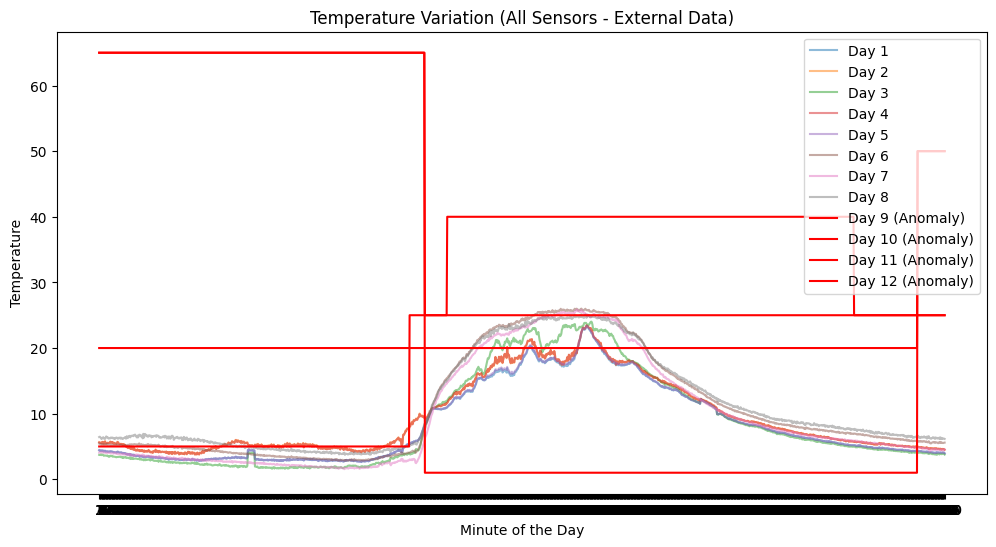

In [ ]:
plt.figure(figsize=(12, 6))
for row in range(external_data.shape[0]):
    if row in anomalies.index:
        plt.plot(external_data.iloc[row, :], label=f"Day {row+1} (Anomaly)", color='r')
    else:
        plt.plot(external_data.iloc[row, :], label=f"Day {row+1}", alpha=0.5)
plt.title('Temperature Variation (All Sensors - External Data)')
plt.xlabel('Minute of the Day')
plt.ylabel('Temperature')
plt.legend()
plt.show()

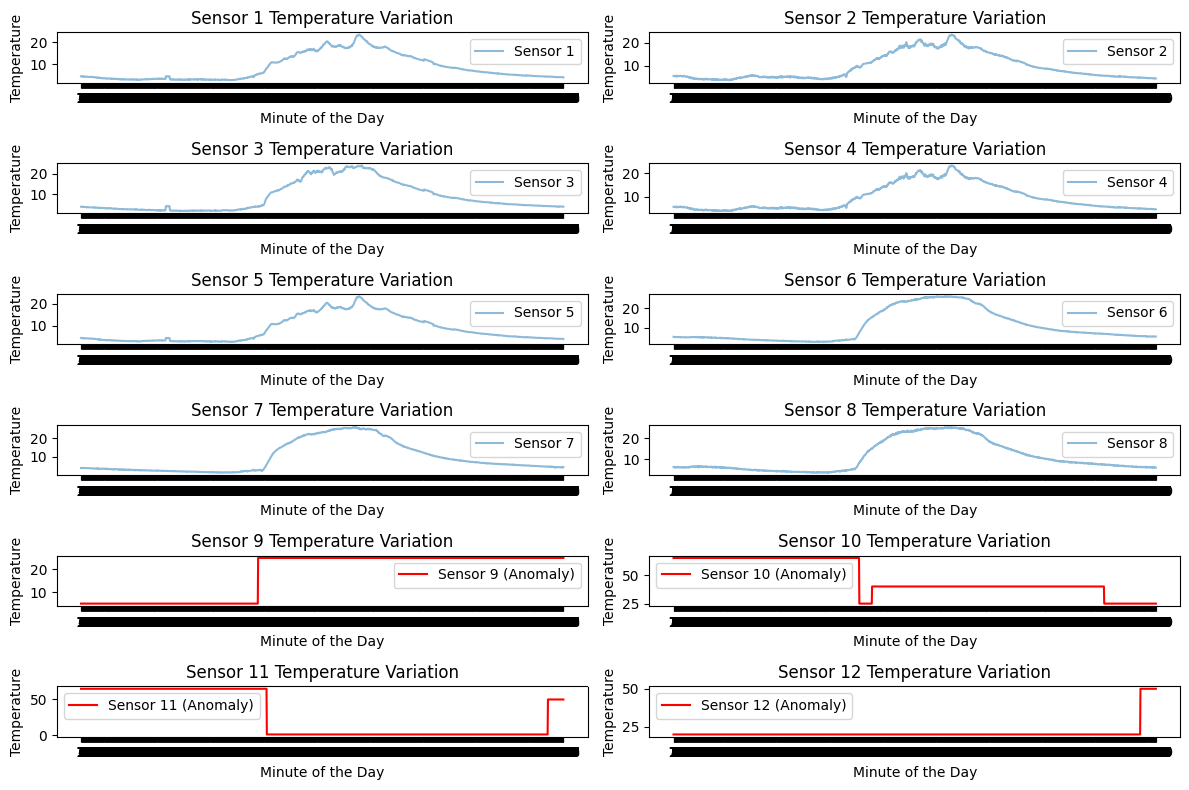

In [ ]:
num_sensors = external_data.shape[0]
num_cols = min(2, num_sensors)
num_rows = (num_sensors + num_cols - 1) // num_cols

# Plotting temperature variation for each sensor individually with anomalies highlighted
plt.figure(figsize=(12, 8))
for row in range(num_sensors):
    plt.subplot(num_rows, num_cols, row+1)
    if row in anomalies.index:
        plt.plot(external_data.iloc[row, :], label=f"Sensor {row+1} (Anomaly)", color='r')
    else:
        plt.plot(external_data.iloc[row, :], label=f"Sensor {row+1}", alpha=0.5)
    plt.title(f"Sensor {row+1} Temperature Variation")
    plt.xlabel('Minute of the Day')
    plt.ylabel('Temperature')
    plt.legend()
plt.tight_layout()
plt.show()
